In [1]:
import string
import re
from pickle import dump
from unicodedata import normalize
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [3]:
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs


In [4]:
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)


In [5]:
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = 'fra.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-french.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-french.pkl
[go] => [va]
[hi] => [salut]
[hi] => [salut]
[run] => [cours]
[run] => [courez]
[who] => [qui]
[wow] => [ca alors]
[fire] => [au feu]
[help] => [a laide]
[jump] => [saute]
[stop] => [ca suffit]
[stop] => [stop]
[stop] => [arretetoi]
[wait] => [attends]
[wait] => [attendez]
[go on] => [poursuis]
[go on] => [continuez]
[go on] => [poursuivez]
[hello] => [bonjour]
[hello] => [salut]
[i see] => [je comprends]
[i try] => [jessaye]
[i won] => [jai gagne]
[i won] => [je lai emporte]
[i won] => [jai gagne]
[oh no] => [oh non]
[attack] => [attaque]
[attack] => [attaquez]
[cheers] => [sante]
[cheers] => [a votre sante]
[cheers] => [merci]
[cheers] => [tchintchin]
[get up] => [levetoi]
[go now] => [va maintenant]
[go now] => [allezy maintenant]
[go now] => [vasy maintenant]
[got it] => [jai pige]
[got it] => [compris]
[got it] => [pige]
[got it] => [compris]
[got it] => [tas capte]
[hop in] => [monte]
[hop in] => [montez]
[hug me] => [serremoi dans tes bras]
[hug me] => 

In [7]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

    
#load dataset
raw_dataset = load_clean_sentences('english-french.pkl')
 
# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-french-both.pkl')
save_clean_data(train, 'english-french-train.pkl')
save_clean_data(test, 'english-french-test.pkl')

Saved: english-french-both.pkl
Saved: english-french-train.pkl
Saved: english-french-test.pkl


In [8]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# load datasets
dataset = load_clean_sentences('english-french-both.pkl')
train = load_clean_sentences('english-french-train.pkl')
test = load_clean_sentences('english-french-test.pkl')

In [9]:
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [10]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word

In [11]:
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 

In [13]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [14]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

In [15]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

English Vocabulary Size: 2122
English Max Length: 5


In [17]:
# prepare german tokenizer
fra_tokenizer = create_tokenizer(dataset[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(dataset[:, 1])
print('French Vocabulary Size: %d' % fra_vocab_size)
print('French Max Length: %d' % (fra_length))

French Vocabulary Size: 4375
French Max Length: 10


In [18]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 256)           1120000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 2122)           545354    
Total params: 2,715,978
Trainable params: 2,715,978
Non-trainable params: 0
_________________________________________________________________
None


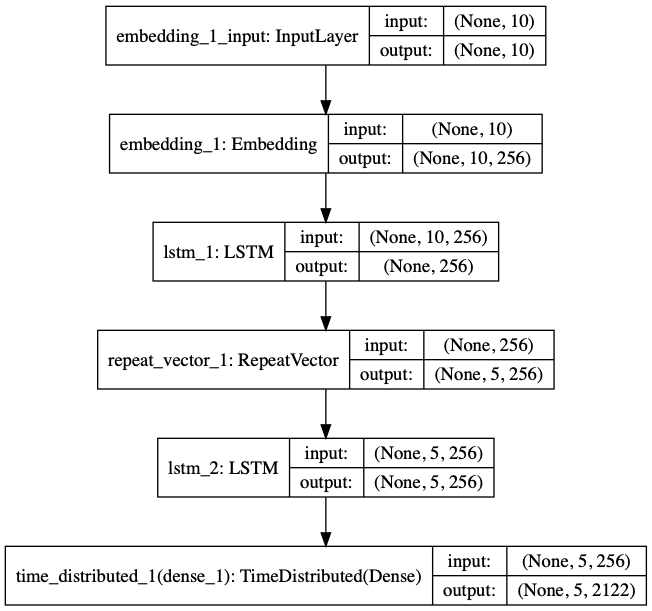

In [19]:
# define model
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [20]:
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
 - 18s - loss: 4.2336 - val_loss: 3.4074

Epoch 00001: val_loss improved from inf to 3.40740, saving model to model.h5
Epoch 2/30
 - 17s - loss: 3.2652 - val_loss: 3.2169

Epoch 00002: val_loss improved from 3.40740 to 3.21691, saving model to model.h5
Epoch 3/30
 - 19s - loss: 3.1047 - val_loss: 3.1245

Epoch 00003: val_loss improved from 3.21691 to 3.12446, saving model to model.h5
Epoch 4/30
 - 17s - loss: 2.9631 - val_loss: 2.9835

Epoch 00004: val_loss improved from 3.12446 to 2.98345, saving model to model.h5
Epoch 5/30
 - 19s - loss: 2.7736 - val_loss: 2.8522

Epoch 00005: val_loss improved from 2.98345 to 2.85220, saving model to model.h5
Epoch 6/30
 - 19s - loss: 2.6036 - val_loss: 2.7381

Epoch 00006: val_loss improved from 2.85220 to 2.73806, saving model to model.h5
Epoch 7/30
 - 18s - loss: 2.4442 - val_loss: 2.6465

Epoch 00007: val_loss improved from 2.73806 to 2.64647, saving model to model.h5
Epoch 8/30
 - 19s 

## Validation

In [21]:
# load datasets
dataset = load_clean_sentences('english-french-both.pkl')
train = load_clean_sentences('english-french-train.pkl')
test = load_clean_sentences('english-french-test.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
fra_tokenizer = create_tokenizer(dataset[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])

In [22]:
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [23]:
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [24]:
# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('test')
evaluate_model(model, eng_tokenizer, testX, test)

train
src=[etesvous fatigue], target=[are you tired], predicted=[are you tired]
src=[estu pret], target=[are you ready], predicted=[are you ready]
src=[ne sois pas en retard], target=[dont be late], predicted=[dont be late]
src=[sagitil dune blague], target=[is this a joke], predicted=[is this a joke]
src=[laissezmoi tranquille], target=[leave me alone], predicted=[leave me alone]
src=[soyez raisonnable], target=[be sensible], predicted=[be sensible]
src=[ca ne peut pas attendre], target=[it cant wait], predicted=[it cant help]
src=[je plaisante], target=[i am joking], predicted=[i am joking]
src=[je porte des lunettes], target=[i wear glasses], predicted=[i wear glasses]
src=[cest visible], target=[thats evident], predicted=[thats evident]
BLEU-1: 0.904509
BLEU-2: 0.866842
BLEU-3: 0.772540
BLEU-4: 0.452085
test
src=[estu reveille], target=[are you awake], predicted=[are you awake]
src=[puisje terminer], target=[can i finish], predicted=[may i begin]
src=[il est canadien], target=[he i